In [1]:
#import modules
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

In [2]:
#read file & create non directed instance
vertexCount = 0
edgeCount = 0
edgeList = []
file = open("edges.txt", "r")
if file.mode == 'r':
    instance = file.readlines()
    for index, row in enumerate(instance):
        if("p edge" in row):
            str = row.split()
            vertexCount = int(str[2])
            edgeCount = int(str[3])
        if(index >= 2):
            edgeList.append(row.strip())
edgeList = edgeList[0::2]


In [3]:
print ('vertexCount : ',vertexCount,'\nallEdgeCount : ',edgeCount,'\nedgeCount : ',len(edgeList),'\nedgeList : ',edgeList)

vertexCount :  40 
allEdgeCount :  224 
edgeCount :  112 
edgeList :  ['e 1 8', 'e 1 19', 'e 1 20', 'e 1 31', 'e 2 7', 'e 2 12', 'e 2 20', 'e 2 27', 'e 3 4', 'e 3 12', 'e 3 16', 'e 4 5', 'e 4 10', 'e 4 13', 'e 4 33', 'e 4 37', 'e 4 38', 'e 5 9', 'e 5 11', 'e 5 13', 'e 5 17', 'e 5 22', 'e 5 38', 'e 6 26', 'e 6 33', 'e 7 10', 'e 7 13', 'e 7 26', 'e 7 27', 'e 8 11', 'e 8 14', 'e 8 17', 'e 8 24', 'e 8 35', 'e 9 19', 'e 9 23', 'e 9 37', 'e 10 12', 'e 10 15', 'e 10 31', 'e 11 18', 'e 11 23', 'e 11 34', 'e 12 17', 'e 12 18', 'e 12 22', 'e 12 29', 'e 12 34', 'e 12 37', 'e 13 15', 'e 13 17', 'e 13 30', 'e 13 33', 'e 13 36', 'e 13 39', 'e 14 28', 'e 14 32', 'e 14 37', 'e 14 39', 'e 14 40', 'e 15 24', 'e 15 25', 'e 16 17', 'e 16 20', 'e 16 21', 'e 16 25', 'e 16 28', 'e 17 25', 'e 18 20', 'e 18 21', 'e 18 25', 'e 18 35', 'e 18 37', 'e 19 24', 'e 19 27', 'e 19 39', 'e 20 23', 'e 20 30', 'e 20 34', 'e 21 31', 'e 21 38', 'e 22 26', 'e 22 27', 'e 22 29', 'e 22 33', 'e 22 37', 'e 23 31', 'e 24 37', 'e 

In [4]:
#create dataFrame
df = pd.DataFrame({ 'from':[], 'to':[]})
for idx, val in enumerate(edgeList):
    str = val.split()
    df.loc[idx] = [str[1],str[2]]
df.head()

from  to
0    1   8
1    1  19
2    1  20
3    1  31
4    2   7

In [5]:
# create input graph
G = nx.from_pandas_edgelist(df, 'from', 'to')
 

c:\users\dour-andish\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


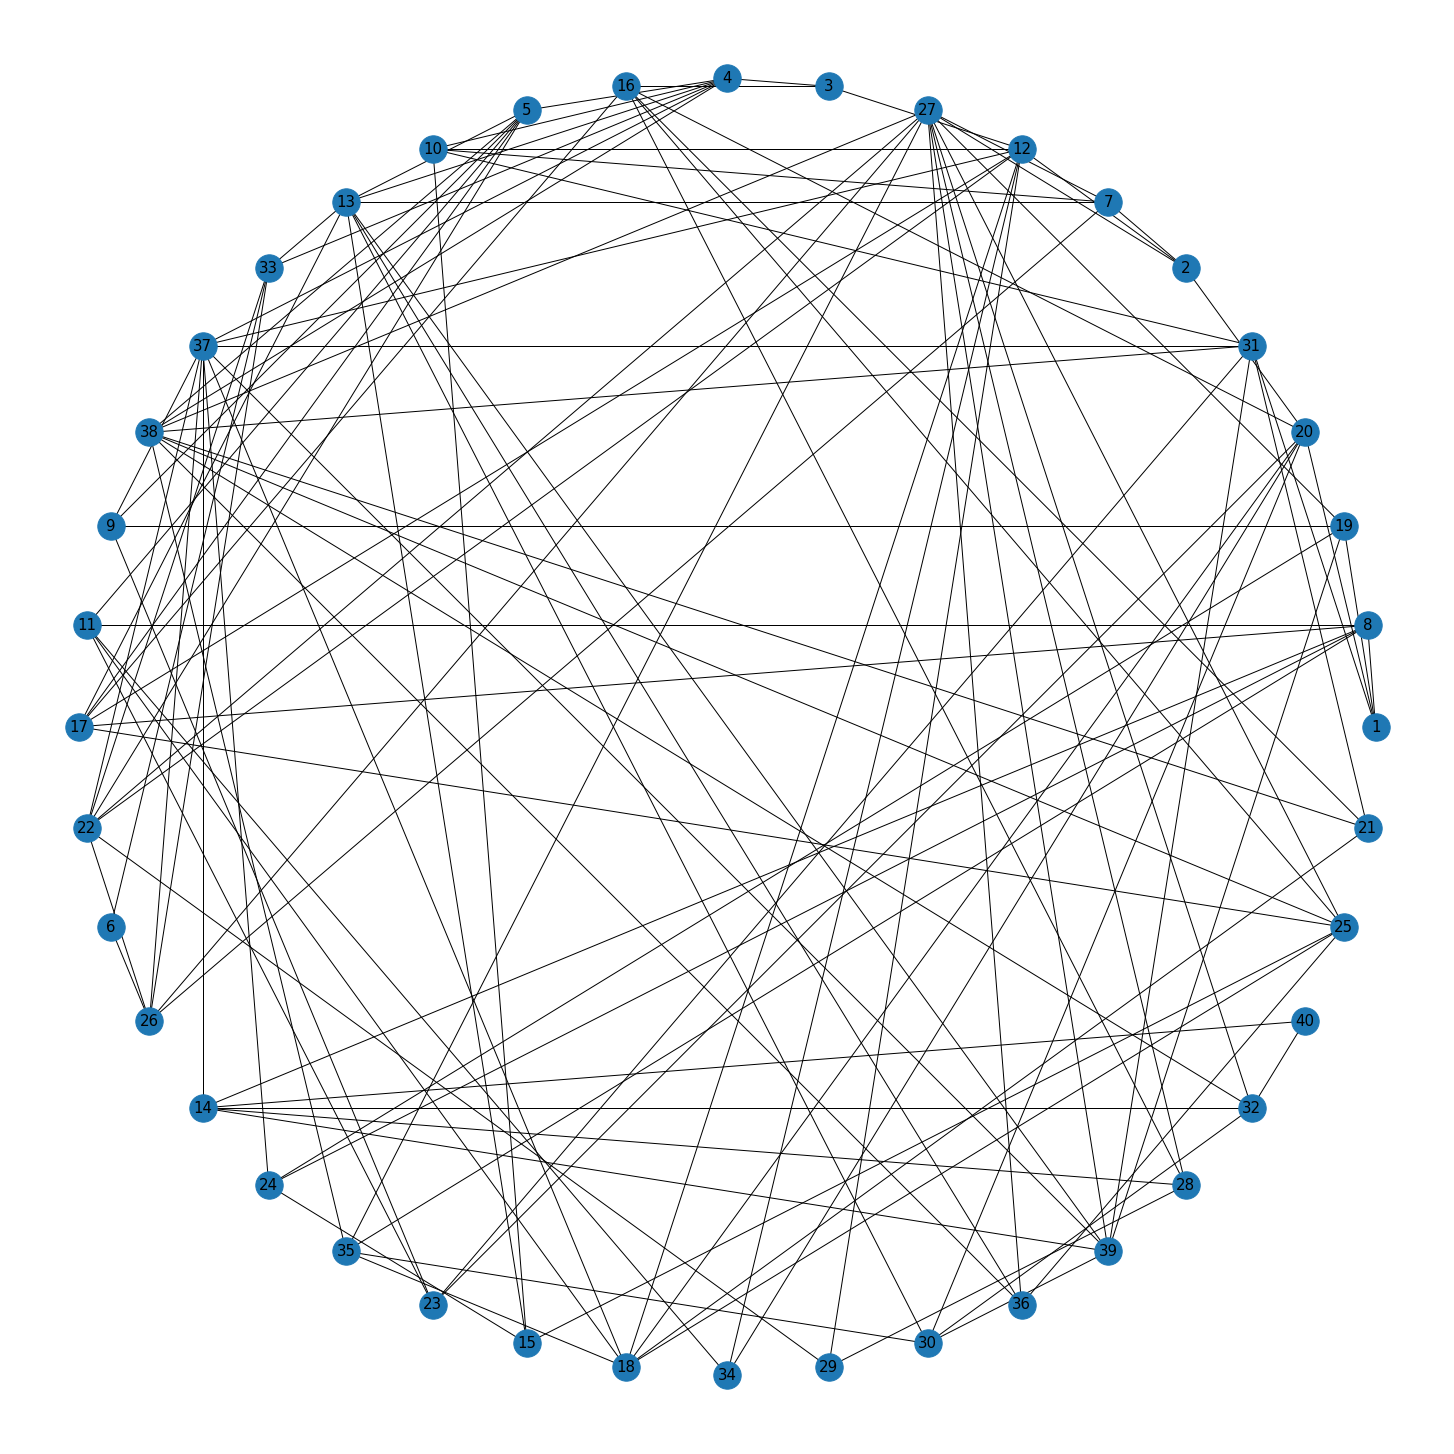

In [6]:
# show input graph
plt.figure(figsize=(20,20))  
nx.draw_circular(G, with_labels=True,font_size=15,node_size=750)    
plt.show()

In [7]:
#create complement graph
G_cmpl = nx.complement(G)


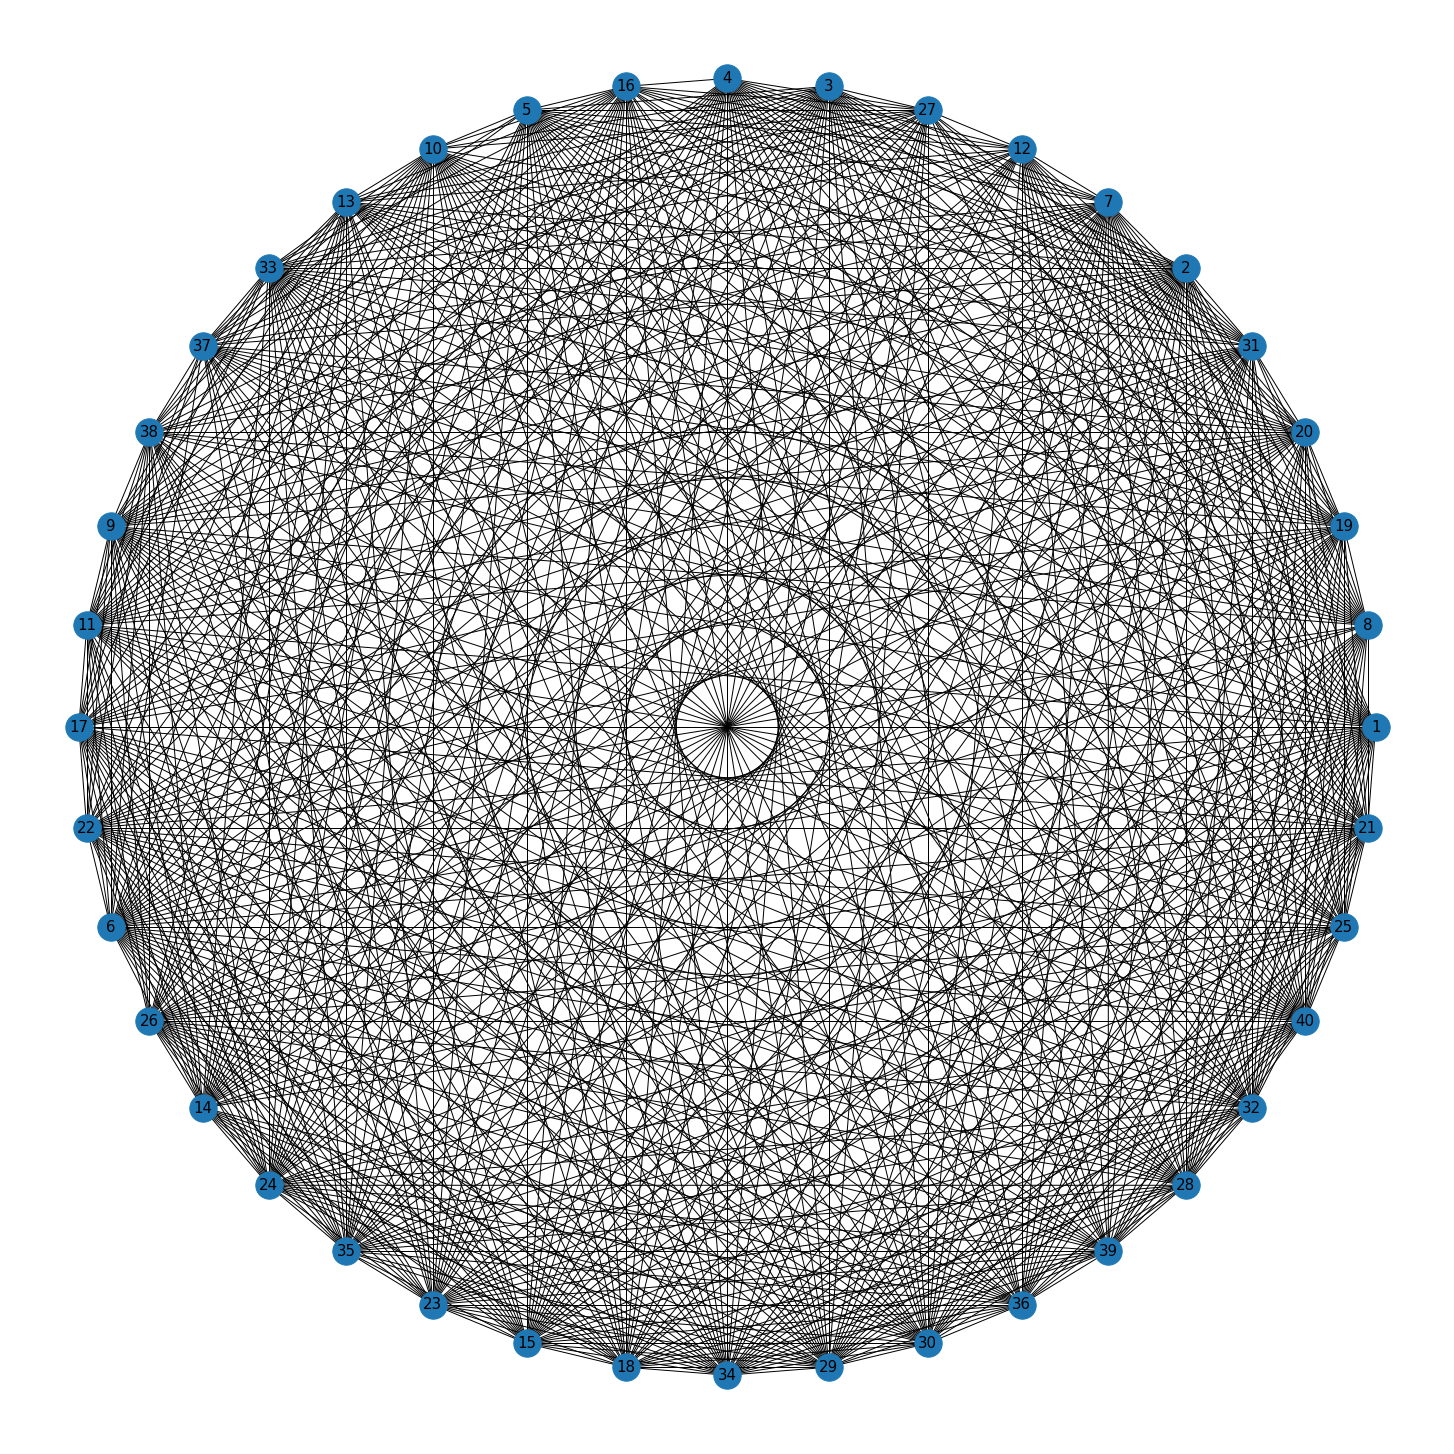

In [8]:
#show complement graph
plt.figure(figsize=(20,20)) 
nx.draw_circular(G_cmpl, with_labels=True,font_size=15,node_size=750)  
plt.show()

In [9]:
#create a list of input graph edges & complement edgs 
curEdge = []
for ed in G.edges:
    if(int(ed[0]) < int(ed[1])):
        name = "x{}-{}".format(ed[0],ed[1])
        curEdge.append(name)
    else:
        name = "x{}-{}".format(ed[1],ed[0])
        curEdge.append(name)
    
cmplEdge = []
for ed in G_cmpl.edges:
    if(int(ed[0]) < int(ed[1])):
        name = "x{}-{}".format(ed[0],ed[1])
        cmplEdge.append(name)
    else:
        name = "x{}-{}".format(ed[1],ed[0])
        cmplEdge.append(name)

In [10]:
#graph info
print('graph node counts : ',len(G.nodes),'\ngraph edge counts : ',len(G.edges))

graph node counts :  40 
graph edge counts :  112


In [11]:
#import module for ILP
from pulp import *

In [12]:
#create a minimization ILP 
prob = LpProblem("cluster editing ILP",LpMinimize)

In [13]:
#get all edges
allEdge = curEdge + cmplEdge

In [14]:
#create variables per all edges
edge_vars = LpVariable.dicts("Edge", allEdge, lowBound=0, upBound=1, cat=LpInteger)

In [15]:
#create cost function
objective = lpSum([(1 - edge_vars[i]) for i in curEdge]) + lpSum([edge_vars[j] for j in cmplEdge])

In [16]:
#add cost function to problem
prob.setObjective(objective)

In [17]:
#create Conditions
for i in (range(1, len(G.nodes) + 1)):
    for j in (range(1,i)):
        for k in (range(1,j)):
            xij = "x{}-{}".format(k,j)
            xjk = "x{}-{}".format(j,i)
            xik = "x{}-{}".format(k,i)
            prob += (edge_vars[xij] + edge_vars[xjk] - edge_vars[xik]) <= 1
            prob += (edge_vars[xij] - edge_vars[xjk] + edge_vars[xik]) <= 1
            prob += (-edge_vars[xij] + edge_vars[xjk] + edge_vars[xik]) <= 1

In [18]:
#solve problem & get solving time per minute
start = time.time()
prob.solve()
end = time.time()
print((end - start)/60)

3.942099964618683


In [19]:
#problem status & cost
print("Status:", LpStatus[prob.status])
obj = value(prob.objective)
print("The cost of objective function: {}".format(obj))

Status: Optimal
The cost of objective function: 81.0


In [20]:
#solution edges
edgeList = []
for v in prob.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)
        name = v.name.split('_')
        edgeList.append(name[1].replace('x','') + ' ' + name[2])

Edge_x11_34 = 1.0
Edge_x12_18 = 1.0
Edge_x12_37 = 1.0
Edge_x13_17 = 1.0
Edge_x14_32 = 1.0
Edge_x14_40 = 1.0
Edge_x15_24 = 1.0
Edge_x18_37 = 1.0
Edge_x1_19 = 1.0
Edge_x21_31 = 1.0
Edge_x22_26 = 1.0
Edge_x22_33 = 1.0
Edge_x25_27 = 1.0
Edge_x25_36 = 1.0
Edge_x25_38 = 1.0
Edge_x26_33 = 1.0
Edge_x27_36 = 1.0
Edge_x27_38 = 1.0
Edge_x28_29 = 1.0
Edge_x2_20 = 1.0
Edge_x30_39 = 1.0
Edge_x32_40 = 1.0
Edge_x36_38 = 1.0
Edge_x3_16 = 1.0
Edge_x4_13 = 1.0
Edge_x4_17 = 1.0
Edge_x4_5 = 1.0
Edge_x5_13 = 1.0
Edge_x5_17 = 1.0
Edge_x6_22 = 1.0
Edge_x6_26 = 1.0
Edge_x6_33 = 1.0
Edge_x7_10 = 1.0
Edge_x8_35 = 1.0
Edge_x9_23 = 1.0


In [21]:
dfSol = pd.DataFrame({ 'from':[], 'to':[]})

for idx, val in enumerate(edgeList):
    str = val.split()
    dfSol.loc[idx] = [str[0],str[1]]

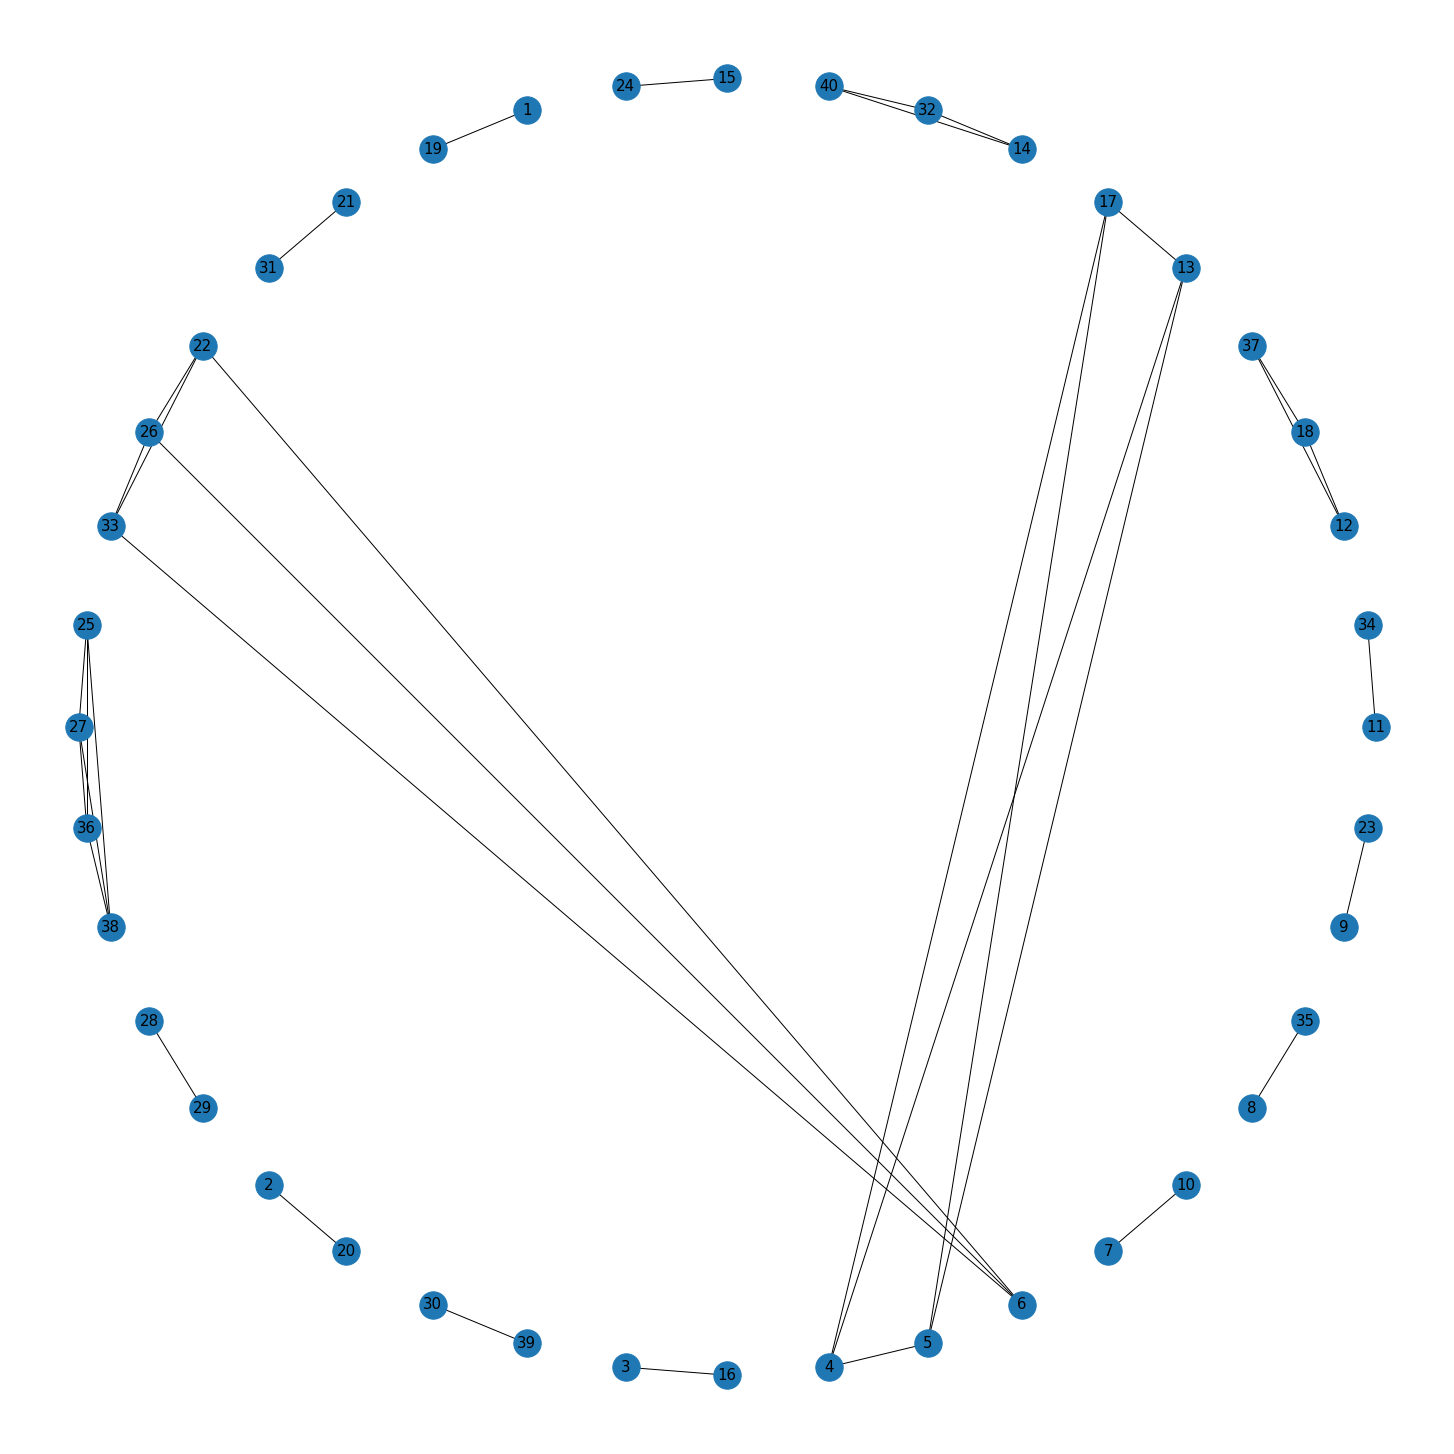

35


In [22]:
# create solution graph
GOPT = nx.from_pandas_edgelist(dfSol, 'from', 'to')

plt.figure(figsize=(20,20)) 
 
nx.draw_circular(GOPT, with_labels=True,font_size=15,node_size=750)  

plt.show()

print(len(GOPT.edges))